# Gather insights from the experiments run on GCP

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from common.utils import check_missing_experiments, join_df
from common.metrics import *

## Define the TTA Formula 

In [2]:
# Calculate time to accuracy for different accuracies
def tta_crossbow(acc:int, df: pd.DataFrame, acc_column='accuracy', time_column='epoch_duration'):
    """Computes the tta as in the crossbow paper
    where the tta is the median of the last 5 epochs"""

    res = []
    for _, row in df.iterrows():
        done = False
        dur, accuracy = row[time_column], row[acc_column]
        
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
            
            # if there are less than 5 elements behind, continue
            if idx < 4:
                continue
                
            # calculate the median of the next five elements
            if np.median(accuracy[idx - 4:idx+1]) >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res


def tta(acc:int, df:pd.DataFrame,  acc_column='accuracy', time_column='epoch_duration'):
    
    
    res = []
    for _, row in df.iterrows():
        done=False
        dur, accuracy = row[time_column], row[acc_column]
        
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
         
            if a >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res
        

# KubeML Experiments

How to treat the kubeml experiments

### Load the train results

In [96]:
df = join_df('./results/lenet/train')

In [ ]:
# get duplicated rows
df[df.duplicated(['hash'], keep=False)]

Define the extra variables

In [97]:
# Set the acc to the final accuracy
df['acc'] = df.accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.epoch_duration.map(lambda t: t[-1])

# Set the parallelism to the first since it is constant
df.parallelism = df.parallelism.map(lambda l:l[0])

# change -1 to inf so the order is right in the plot
df.k = df.k.map(lambda val: float('inf') if val == -1 else val)

df['global_batch'] = df.batch_size * df.parallelism




In [98]:
# compute the ttas
df['tta_99'] = tta(99, df)
df['tta_cross_99'] = tta_crossbow(99, df)

### For the metrics in the lenet

The first replication does not have the proper format, so we need to reformat it and combine it with the train results

In [99]:
metrics1 = join_df('./results/lenet/metrics/1/')
metrics2 = join_df('./results/lenet/metrics/2/')
metrics3 = join_df('./results/lenet/metrics/3/')

cpu = metrics1.groupby('exp_name')['cpu'].apply(list)
mem = metrics1.groupby('exp_name')['mem'].apply(list)
exps = metrics1.groupby('exp_name')['exp_name']

metrics1 = pd.DataFrame({
    'cpu':cpu,
    'mem':mem
})
metrics1['exp_name'] = metrics1.index

# concat all metrics and rename the exp_name as in the train
m = pd.concat([metrics1, metrics2, metrics3], ignore_index=True)
m.rename(columns={'exp_name':'id'}, inplace=True)


Now we need to add extra summary columns to the metrics

In [100]:
# functions to compute the mean of each and add columns
m['mem'] = m['mem'].map(lambda l: l[0] if isinstance(l[0], list) else l)
m['cpu'] = m['cpu'].map(lambda l: l[0] if isinstance(l[0], list) else l)

# cpu util
m['cpu_mean'] = m['cpu'].map(lambda l: np.mean([s.percent for s in l]))

# gpu mean mem and util
m['gpu_0_mean_usage'] = m['gpu_0'].map(lambda l: np.mean([s.load for s in l if s.mem_used != 0]) if not isinstance(l, float) else l)
m['gpu_1_mean_usage'] = m['gpu_1'].map(lambda l: np.mean([s.load for s in l if s.mem_used !=0]) if not isinstance(l, float) else l)
m['gpu_0_mean_memory'] = m['gpu_0'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_1_mean_memory'] = m['gpu_1'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_usage'] = (m['gpu_0_mean_usage'] + m['gpu_1_mean_usage']) /2

# memory mean util
m['mem_mean'] = m['mem'].map(lambda l: np.mean([s.percent for s in l]))

#### Combine and Save the whole experiment

In [101]:
d = df.merge(m, on='id')
d.to_pickle('./dataframes/lenet_kubeml.pkl')

# TensorFlow Experiments

How to treat the TF experiments

In [37]:
df = join_df('./results/tf/lenet/train/1/', './results/tf/lenet/train/2', './results/tf/lenet/train/3')

# Set the acc to the final accuracy
df['acc'] = df.val_accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.times.map(lambda t: t[-1])



In [91]:
# Define the TTA
df['tta_69'] = tta(0.69, df, time_column='times', acc_column='val_accuracy')
df['tta_cross_69'] = tta_crossbow(0.69, df, time_column='times', acc_column='val_accuracy')

## Merge the metrics from different  folders


In [38]:
m = join_df('./results/tf/lenet/metrics/1/', './results/tf/lenet/metrics/2', './results/tf/lenet/metrics/3')

In [39]:
# functions to compute the mean of each and add columns
m['mem'] = m['mem'].map(lambda l: l[0] if isinstance(l[0], list) else l)
m['cpu'] = m['cpu'].map(lambda l: l[0] if isinstance(l[0], list) else l)

# cpu util
m['cpu_mean'] = m['cpu'].map(lambda l: np.mean([s.percent for s in l]))

# gpu mean mem and util
m['gpu_0_mean_usage'] = m['gpu_0'].map(lambda l: np.mean([s.load for s in l if s.mem_used != 0]) if not isinstance(l, float) else l)
m['gpu_1_mean_usage'] = m['gpu_1'].map(lambda l: np.mean([s.load for s in l if s.mem_used !=0]) if not isinstance(l, float) else l)
m['gpu_0_mean_memory'] = m['gpu_0'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_1_mean_memory'] = m['gpu_1'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_usage'] = (m['gpu_0_mean_usage'] + m['gpu_1_mean_usage']) /2

# memory mean util
m['mem_mean'] = m['mem'].map(lambda l: np.mean([s.percent for s in l]))

Join on the index

In [40]:
df = df.join(m)

Save the experiments

In [95]:
df.to_pickle('./dataframes/lenet_kubeml.pkl')

# Visualization of Results


Set the color palette

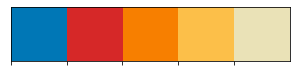

In [8]:
green_red_palette = ['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51']
blue_yellow_palette=  ['#0077b6', '#d62828', '#f77f00', '#fcbf49', '#eae2b7']
cool_p = ['#f87575', '#ffa9a3', '#b9e6ff', '#5c95ff', '#7e6c6c']
wall_p = ['#e63946', '#f1faee', '#a8dadc', '#457b9d', '#1d3557']

sns.palplot(sns.color_palette(blue_yellow_palette))


sns.set_theme(style='whitegrid', palette=blue_yellow_palette, )
# sns.set_palette(blue_yellow_palette)

#### Read the experiments file

In [103]:
experiment_file = './dataframes/lenet_kubeml.pkl'
df = pd.read_pickle(experiment_file)
df

,id,hash,model_type,batch_size,epochs,dataset,lr,function_name,default_parallelism,static_parallelism,...,mem,gpu_0,gpu_1,cpu_mean,gpu_0_mean_usage,gpu_1_mean_usage,gpu_0_mean_memory,gpu_1_mean_memory,gpu_usage,mem_mean
0,01da4199,11bd6f57e69e3e22,example,128,30,mnist,0.01,lenet,1,True,...,"[MemoryStats(total=270332.669952, free=199405....","[GpuStats(id=0, name='GeForce RTX 2080 Ti', lo...","[GpuStats(id=1, name='GeForce RTX 2080 Ti', lo...",3.123596,0.042941,0.000000,2057.858824,3.000000,0.021471,5.598876
1,02bf7ea4,e64b768614e0c4b2,example,64,30,mnist,0.01,lenet,8,True,...,"[MemoryStats(total=270332.669952, free=200200....",NaN,NaN,8.409091,NaN,NaN,NaN,NaN,NaN,9.554545
2,02c2c3e4,ca950a6673f71c02,example,32,30,mnist,0.01,lenet,1,True,...,"[MemoryStats(total=270332.669952, free=199864....",NaN,NaN,3.924390,NaN,NaN,NaN,NaN,NaN,5.716463
3,04ae4d90,c072e7d8b6f4fc7e,example,128,30,mnist,0.01,lenet,8,True,...,"[MemoryStats(total=270332.669952, free=200921....","[GpuStats(id=0, name='GeForce RTX 2080 Ti', lo...","[GpuStats(id=1, name='GeForce RTX 2080 Ti', lo...",7.242424,0.141667,0.112917,5068.458333,4104.083333,0.127292,9.500000
4,06c0714b,9f3c17b028508b1d,example,16,30,mnist,0.01,lenet,2,True,...,"[MemoryStats(total=270332.669952, free=193349....",NaN,NaN,5.877778,NaN,NaN,NaN,NaN,NaN,6.997661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,fc4d208e,e4b3277b60ea90de,example,16,30,mnist,0.01,lenet,8,True,...,"[MemoryStats(total=270332.669952, free=178444....","[GpuStats(id=0, name='GeForce RTX 2080 Ti', lo...","[GpuStats(id=1, name='GeForce RTX 2080 Ti', lo...",13.064151,0.495283,0.414906,5058.113208,4079.000000,0.455094,12.320755
189,fcb9d493,a77733fe0915a9ca,example,128,30,mnist,0.01,lenet,8,True,...,"[MemoryStats(total=270332.669952, free=180601....","[GpuStats(id=0, name='GeForce RTX 2080 Ti', lo...","[GpuStats(id=1, name='GeForce RTX 2080 Ti', lo...",7.747826,0.086522,0.126087,4167.000000,5164.608696,0.106304,11.760870
190,fda9af79,e64b768614e0c4b2,example,64,30,mnist,0.01,lenet,8,True,...,"[MemoryStats(total=270332.669952, free=179894....","[GpuStats(id=0, name='GeForce RTX 2080 Ti', lo...","[GpuStats(id=1, name='GeForce RTX 2080 Ti', lo...",9.100000,0.195769,0.212692,4167.000000,5160.730769,0.204231,11.950000
191,fdf430ea,a31f2f9fde57be67,example,32,30,mnist,0.01,lenet,8,True,...,"[MemoryStats(total=270332.669952, free=199727....",NaN,NaN,9.154545,NaN,NaN,NaN,NaN,NaN,9.769697


### Create new columns for representation

- Final accuracy
- Total time taken
- Parallelism

### Plot the Correlations between the K, Batch and Parallelism with time and accuracy

In [ ]:
corr = df[['k', 'batch_size', 'parallelism', 'acc', 'time']].corr()
sns.heatmap(corr,
            annot=True,
)

# plt.savefig('./figures/resnet34/heat.png', dpi=300)


In [107]:
df.sort_values('time')

mean = df.groupby('hash').mean()

### Get the max accuracies and times and check the parameters used

In [ ]:
# get the max accuracies
df[['k', 'parallelism', 'acc','batch_size','time']].sort_values(by='time', ascending=True)

## Calculate TTA with different accuracies



In [ ]:
s = df.sort_values('tta_cross_99')[['k', 'batch_size', 'parallelism', 'tta_cross_99', 'tta_99', 'acc', 'accuracy', 'epoch_duration']]

# plot the best
best = s.iloc[0]
best


x = range(1, len(best.accuracy)+1)
plt.figure()
plt.title(f'Best tta_99 (B={best.batch_size}, k={best.k}, P={best.parallelism})')
sns.lineplot(x=best.epoch_duration, y = best.accuracy)
sns.lineplot(x=best.epoch_duration, y= 99)
plt.scatter(best.tta_cross_99, 99, marker='X', s=60, c='r')
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Accuracy (%)', fontsize=15)

# plt.savefig('./figures/gpu/best.png', dpi=300)


In [ ]:
best.tta_cross_99

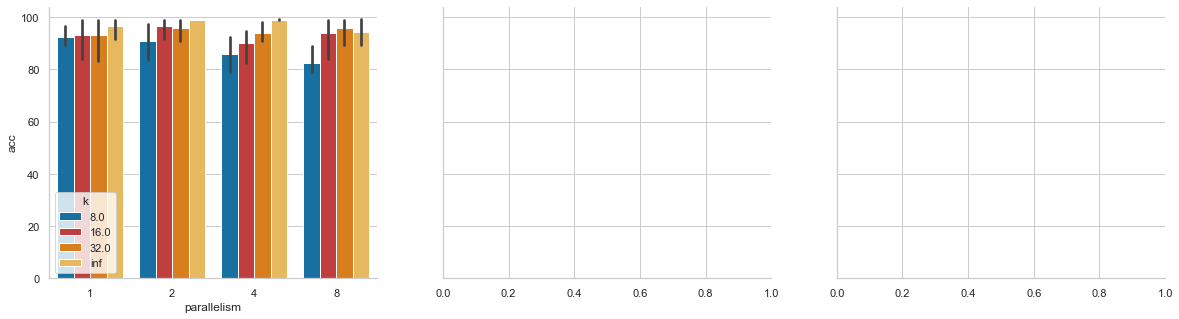

In [118]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
sns.barplot(x='parallelism', y='acc', data=mean, hue='k',  ax=ax[0])
# sns.barplot(x='k', y='tta_cross_99', data=df, ax=ax[1])
# sns.barplot(x='parallelism', y='tta_cross_99', data=df ,ax=ax[2])
sns.despine()

# plt.savefig('./figures/gpu/tta_99.png', dpi=300)

# sns.barplot(x='k', y='tta_99', data=df)

## Do ANOVA Linear Model to calculate the influence of the parameters

Using ANOVA we can get an idea of how the different parameters interact with each other and their influence

In [ ]:
# For the ANOVA test
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
def ANOVA(df: pd.DataFrame, y: str, use_all = False,verbose=False):
    """Run the ANOVA analysis with the batch, k and parallelism columns for the 
    given output variable"""
    
    # If use all is true we use all the variables to check either accuracy and time
    # including also the iowait and the cpu to see what fully influences the stuff
    
    
    if not use_all:
        # Plot the summary dataframe
        if verbose:
            display(rp.summary_cont(df.groupby(['batch_size', 'k', 'parallelism']))[y])

        model = ols(f'{y} ~ batch_size*k*parallelism', df).fit()
        
    else:
        if y not in ['acc', 'time']:
            raise ValueError('When use_all = True we predict either final_accuracy or time, not', y)
        if verbose:
            display(rp.summary_cont(df.groupby(['batch_size', 'k', 'parallelism']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs*cpu_mean*iowait_mean', df).fit()
        

    if verbose:
        print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
        display(model.summary())
    
    res = sm.stats.anova_lm(model, typ=2)
    
    return res, model

In [ ]:
# df.k = df.k.map(lambda val: -1 if val == float('inf') else val)

res, model = ANOVA(d, y='gpu_usage', verbose=True)

res



### Plot the distributions of time and accuracy as a function of K, Batch and parallelism

#### Plot the accuracy as a factor

In [ ]:
plt.rc('font', size=16)

f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
sns.barplot(x='batch_size', y='acc', hue='k', data=df, ax=ax[0], capsize=.05)
sns.barplot(x='k', y='acc', data=df, ax=ax[1], capsize=.05, hue='parallelism')
sns.barplot(x='parallelism', y='acc', data=df, hue='k' ,ax=ax[2] ,capsize=.05)
sns.despine()
plt.legend(title='k', ncol=4, bbox_to_anchor=(0.075,1))

for a in ax:
    a.set_ylim([75, 100])



# plt.savefig('./figures/resnet34/accuracy.png', dpi=300)

In [ ]:
plt.rc('font', size=16)
plt.figure(figsize=(15,10))
sns.barplot(x='parallelism', y='tta_cross_99', data=df, capsize=.02, hue='batch_size')


# plt.savefig('./figures/resnet34/acc_per_k_and_parallelism.png', dpi=300)

In [86]:
df= pd.read_pickle('./dataframes/lenet_tensorflow.pkl')
d = pd.read_pickle('./dataframes/lenet_kubeml.pkl')
d = d.loc[d.parallelism==2]

In [87]:
d.sort_values('tta_cross_99')[['batch_size', 'tta_cross_99']]

,batch_size,tta_cross_99
128,32,82.370374
23,32,83.256948
160,32,84.316683
162,16,92.441923
79,16,101.195969
43,16,125.816565
154,64,138.775395
45,64,140.742009
144,64,140.943138
8,64,142.674177


#### Plot the time as a factor

<AxesSubplot:xlabel='batch_size', ylabel='tta_cross_99'>

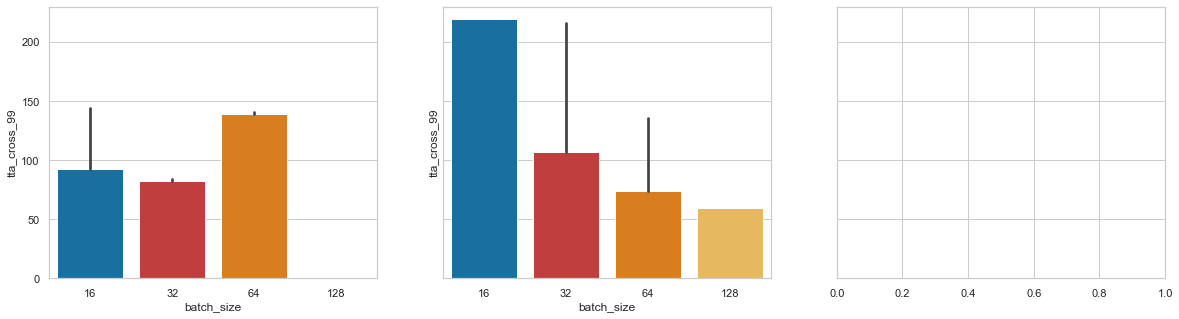

In [88]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
sns.barplot(x='batch_size', y='tta_cross_99', data=d ,ax=ax[0], estimator=np.min)
sns.barplot(x='batch_size', y='tta_cross_99', data=df, ax=ax[1], estimator=np.min)
# sns.barplot(x='parallelism', y='time', data=df, ax=ax[2], hue='k')

# plt.savefig('./figures/resnet34/time.png', dpi=300)

In [ ]:
plt.rc('font', size=16)
f, ax = plt.subplots(1, 3, figsize=(20,8), sharey=True)
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==32], capsize=.05, hue='parallelism', ax=ax[0])
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==64], capsize=.05, hue='parallelism', ax=ax[1])
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==128], capsize=.05, hue='parallelism', ax=ax[2])

plt.savefig('./figures/resnet34/time_per_all.png', dpi=300)

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_k_and_batch(k: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.k==k) & (df.batch_size==batch)].sort_values(by='parallelism', ascending=False)

    plt.rc('font', size=13)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
#             print(row.accuracy)
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, k={k}')
        ax.legend(title='parallelism')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_k_and_batch(k=8, batch=32, ax=axes[0][0])
plot_loss_with_k_and_batch(k=16, batch=32, ax=axes[0][1])   
plot_loss_with_k_and_batch(k=64, batch=32, ax=axes[0][2])
    
plot_loss_with_k_and_batch(k=8, batch=64, ax=axes[1][0])
plot_loss_with_k_and_batch(k=16, batch=64, ax=axes[1][1])   
plot_loss_with_k_and_batch(k=64, batch=64, ax=axes[1][2])

plot_loss_with_k_and_batch(k=8, batch=128, ax=axes[2][0])
plot_loss_with_k_and_batch(k=16, batch=128, ax=axes[2][1])   
plot_loss_with_k_and_batch(k=64, batch=128, ax=axes[2][2])


# plt.savefig('./figures/accuracy_study.png', dpi=300)


#### Keep K and Batch set, vary parallelism

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_k_and_batch(k: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.k==k) & (df.batch_size==batch)].sort_values(by='parallelism', ascending=False)

    plt.rc('font', size=13)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
#             print(row.accuracy)
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, k={k}')
        ax.legend(title='parallelism')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_k_and_batch(k=8, batch=32, ax=axes[0][0])
plot_loss_with_k_and_batch(k=16, batch=32, ax=axes[0][1])   
plot_loss_with_k_and_batch(k=64, batch=32, ax=axes[0][2])
    
plot_loss_with_k_and_batch(k=8, batch=64, ax=axes[1][0])
plot_loss_with_k_and_batch(k=16, batch=64, ax=axes[1][1])   
plot_loss_with_k_and_batch(k=64, batch=64, ax=axes[1][2])

plot_loss_with_k_and_batch(k=8, batch=128, ax=axes[2][0])
plot_loss_with_k_and_batch(k=16, batch=128, ax=axes[2][1])   
plot_loss_with_k_and_batch(k=64, batch=128, ax=axes[2][2])


# plt.savefig('./figures/accuracy_study.png', dpi=300)


#### Keep Parallelism and batch set, vary K

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_parallelism_and_batch(p: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.parallelism==p) & (df.batch_size==batch)].sort_values(by='k', ascending=False)
    
    approx_k = (60000/p)/batch

    plt.rc('font', size=16)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.k))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
            label = str(row.k) if row.k != float('inf') else f'{row.k} ({int(approx_k)})'
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=label)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, Parallelism={p}')
        ax.legend(title='k')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 20), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_parallelism_and_batch(p=2, batch=32, ax=axes[0][0])
plot_loss_with_parallelism_and_batch(p=4, batch=32, ax=axes[0][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=32, ax=axes[0][2])

plot_loss_with_parallelism_and_batch(p=2, batch=64, ax=axes[1][0])
plot_loss_with_parallelism_and_batch(p=4, batch=64, ax=axes[1][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=64, ax=axes[1][2])

plot_loss_with_parallelism_and_batch(p=2, batch=128, ax=axes[2][0])
plot_loss_with_parallelism_and_batch(p=4, batch=128, ax=axes[2][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=128, ax=axes[2][2])


plt.savefig('./figures/accuracy_study_varying_k.png', dpi=300)

#### Plot 3d dependencies between K and parallelism on time and accuracy

In [ ]:
# f, ax = plt.subplots(1, 2, projection='3d')

f = plt.figure()
ax = f.add_subplot(1, 2, 1, projection='3d')

from scipy.interpolate import griddata
X, Y = np.meshgrid(df.k.map(lambda v: 500 if v == float('inf') else v), df.parallelism)
Z = griddata((df.k.map(lambda v: 500 if v == float('inf') else v),
              df.parallelism),
              df.acc, (X, Y), method='cubic')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='coolwarm',
                       linewidth=0, antialiased=False)


In [ ]:
d = df.loc[df.batch==64]